# Unit 4: Central Limit Theorem

In [1]:
from datascience import *
%matplotlib inline
path_data = 'https://gitlab.com/tae-public/data/raw/master/cs61/data8assets/textbook/chapters/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [2]:
#colors = Table.read_table(path_data + 'roulette_wheel.csv').column('Color')

colors = Table.read_table('DataFiles/roulette_wheel.csv').column('Color')

pockets = make_array('0','00')
for i in np.arange(1, 37):
    pockets = np.append(pockets, str(i)) 

wheel = Table().with_columns(
    'Pocket', pockets,
    'Color', colors
)
wheel

Pocket,Color
0,green
00,green
1,red
2,black
3,red
4,black
5,red
6,black
7,red
8,black


### The Central Limit Theorem ###
Very few of the data histograms that we have seen in this course have been bell shaped. When we have come across a bell shaped distribution, it has almost invariably been an empirical histogram of a statistic based on a random sample.

The examples below show two very different situations in which an approximate bell shape appears in such histograms.

### Net Gain in Roulette ###
In an earlier section, the bell appeared as the rough shape of the total amount of money we would make if we placed the same bet repeatedly on different spins of a roulette wheel. 

In [3]:
wheel

Pocket,Color
0,green
00,green
1,red
2,black
3,red
4,black
5,red
6,black
7,red
8,black


Recall that the bet on red pays even money, 1 to 1. We defined the function `red_winnings` that returns the net winnings on one \$1 bet on red. Specifically, the function takes a color as its argument and returns 1 if the color is red. For all other colors it returns -1.

In [4]:
def red_winnings(color):
    if color == 'red':
        return 1
    else:
        return -1

The table `red` shows each pocket's winnings on red.

In [5]:
red = wheel.with_column(
    'Winnings: Red', wheel.apply(red_winnings, 'Color')
    )
red

Pocket,Color,Winnings: Red
0,green,-1
00,green,-1
1,red,1
2,black,-1
3,red,1
4,black,-1
5,red,1
6,black,-1
7,red,1
8,black,-1


Your net gain on one bet is one random draw from the `Winnings: Red` column. There is an 18/38 chance making \$1, and a 20/38 chance of making -\$1. This probability distribution is shown in the histogram below.

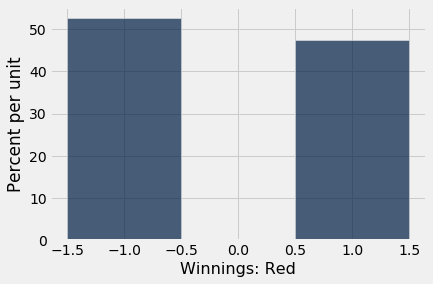

In [6]:
red.select('Winnings: Red').hist(bins=np.arange(-1.5, 1.6, 1))

Now suppose you bet many times on red. Your net winnings will be the sum of many draws made at random with replacement from the distribution above.

It will take a bit of math to list all the possible values of your net winnings along with all of their chances. We won't do that; instead, we will approximate the probability distribution by simulation, as we have done all along in this course. 

The code below simulates your net gain if you bet \$1 on red on 400 different spins of the roulette wheel. 

In [7]:
num_bets = 400
repetitions = 10000

net_gain_red = make_array()

for i in np.arange(repetitions):
    spins = red.sample(num_bets)
    new_net_gain_red = spins.column('Winnings: Red').sum()
    net_gain_red = np.append(net_gain_red, new_net_gain_red)


results = Table().with_column(
    'Net Gain on Red', net_gain_red
    )

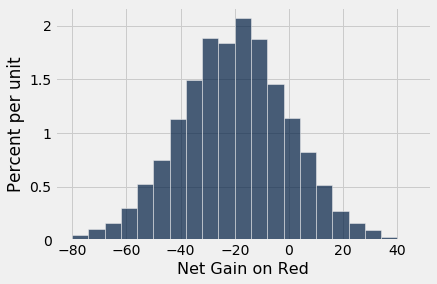

In [8]:
results.hist(bins=np.arange(-80, 50, 6))

That's a roughly bell shaped histogram, even though the distribution we are drawing from is nowhere near bell shaped.

**Center.** The distribution is centered near -20 dollars, roughly. To see why, note that your winnings will be \$1 on about 18/38 of the bets, and -$1 on the remaining 20/38. So your average winnings per dollar bet will be roughly -5.26 cents:

In [9]:
average_per_bet = 1*(18/38) + (-1)*(20/38)
average_per_bet

-0.05263157894736842

So in 400 bets you expect that your net gain will be about -\$21:

In [10]:
400 * average_per_bet

-21.052631578947366

For confirmation, we can compute the mean of the 10,000 simulated net gains:

In [11]:
np.mean(results.column(0))

-21.0356

**Spread.** Run your eye along the curve starting at the center and notice that the point of inflection is near 0. On a bell shaped curve, the SD is the distance from the center to a point of inflection. The center is roughly -\$20, which means that the SD of the distribution is around \$20.

In the next section we will see where the \$20 comes from. For now, let's confirm our observation by simply calculating the SD of the 10,000 simulated net gains:

In [12]:
np.std(results.column(0))

20.08538604657625

**Summary.** The net gain in 400 bets is the sum of the 400 amounts won on each individual bet. The probability distribution of that sum is approximately normal, with an average and an SD that we can approximate.

### Average Flight Delay ###
The table `united` contains data on departure delays of 13,825 United Airlines domestic flights out of San Francisco airport in the summer of 2015. As we have seen before, the distribution of delays has a long right-hand tail.

In [13]:
#united = Table.read_table(path_data + 'united_summer2015.csv')
united = Table.read_table('DataFiles/united_summer2015.csv')

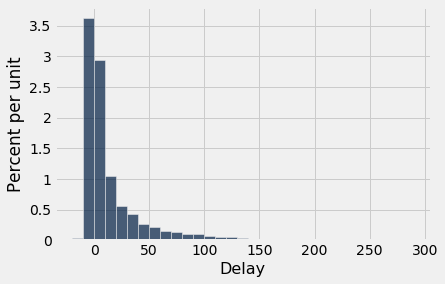

In [14]:
united.select('Delay').hist(bins=np.arange(-20, 300, 10))

The mean delay was about 16.6 minutes and the SD was about 39.5 minutes. Notice how large the SD is, compared to the mean. Those large deviations on the right have an effect, even though they are a very small proportion of the data.

In [15]:
mean_delay = np.mean(united.column('Delay'))
sd_delay = np.std(united.column('Delay'))

mean_delay, sd_delay

(16.658155515370705, 39.480199851609314)

Now suppose we sampled 400 delays at random with replacement. You could sample without replacement if you like, but the results would be very similar to with-replacement sampling. If you sample a few hundred out of 13,825 without replacement, you hardly change the population each time you pull out a value.

In the sample, what could the average delay be? We expect it to be around 16 or 17, because that's the population average; but it is likely to be somewhat off. Let's see what we get by sampling. We'll work with the table `delay` that only contains the column of delays.

In [16]:
delay = united.select('Delay')

In [17]:
np.mean(delay.sample(400).column('Delay'))

16.485

The sample average varies according to how the sample comes out, so we will simulate the sampling process repeatedly and draw the empirical histogram of the sample average. That will be an approximation to the probability histogram of the sample average.

In [18]:
sample_size = 400
repetitions = 10000

means = make_array()

for i in np.arange(repetitions):
    sample = delay.sample(sample_size)
    new_mean = np.mean(sample.column('Delay'))
    means = np.append(means, new_mean)

results = Table().with_column(
    'Sample Mean', means
)

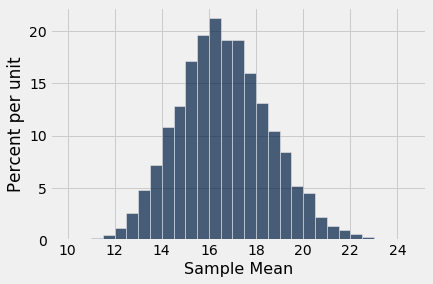

In [19]:
results.hist(bins=np.arange(10, 25, 0.5))

Once again, we see a rough bell shape, even though we are drawing from a very skewed distribution. The bell is centered somewhere between 16 ad 17, as we expect.

### Central Limit Theorem ###

The reason why the bell shape appears in such settings is a remarkable result of probability theory called the **Central Limit Theorem**. 

**The Central Limit Theorem says that the probability distribution of the sum or average of a large random sample drawn with replacement will be roughly normal, *regardless of the distribution of the population from which the sample is drawn*.**

As we noted when we were studying Chebychev's bounds, results that can be applied to random samples *regardless of the distribution of the population* are very powerful, because in data science we rarely know the distribution of the population.

The Central Limit Theorem makes it possible to make inferences with very little knowledge about the population, provided we have a large random sample. That is why it is central to the field of statistical inference.

### Proportion of Purple Flowers ###
Recall Mendel's probability model for the colors of the flowers of a species of pea plant. The model says that the flower colors of the plants are like draws made at random with replacement from {Purple, Purple, Purple, White}.

In a large sample of plants, about what proportion will have purple flowers? We would expect the answer to be about 0.75, the proportion purple in the model. And, because proportions are means, the Central Limit Theorem says that the distribution of the sample proportion of purple plants is roughly normal.

We can confirm this by simulation. Let's simulate the proportion of purple-flowered plants in a sample of 200 plants.

In [20]:
colors = make_array('Purple', 'Purple', 'Purple', 'White')

model = Table().with_column('Color', colors)

model

Color
Purple
Purple
Purple
White


In [21]:
num_plants = 10
sample = model.sample(num_plants)
print('Sample of 10 flowers =',sample)

purple_count = np.count_nonzero(sample.column('Color') == 'Purple')
print('Total purple flowers =',purple_count)

prop = purple_count/num_plants
print('Proportion = ',prop)

Sample of 10 flowers = Color
Purple
Purple
White
White
Purple
Purple
Purple
Purple
White
Purple
Total purple flowers = 7
Proportion =  0.7


In [22]:
props = make_array()

num_plants = 200
repetitions = 10000

for i in np.arange(repetitions):
    sample = model.sample(num_plants)
    new_prop = np.count_nonzero(sample.column('Color') == 'Purple')/num_plants
    props = np.append(props, new_prop)
    

print(results)
results = Table().with_column('Sample Proportion: 200', props)

Sample Mean
15.1525
18.6975
17.0175
15.1675
18.8075
16.375
19.54
16.82
19.165
15.575
... (9990 rows omitted)


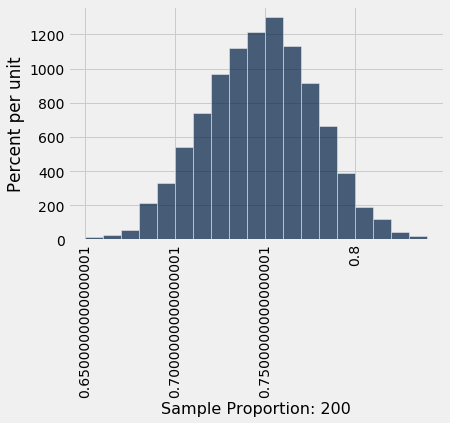

In [23]:
results.hist(bins=np.arange(0.65, 0.85, 0.01))

There's that normal curve again, as predicted by the Central Limit Theorem, centered at around 0.75 just as you would expect.

How would this distribution change if we increased the sample size? Let's run the code again with a sample size of 800, and collect the results of simulations in the same table in which we collected simulations based on a sample size of 200. We will keep the number of `repetitions` the same as before so that the two columns have the same length.

In [24]:
props2 = make_array()

num_plants = 800

for i in np.arange(repetitions):
    sample = model.sample(num_plants)
    new_prop = np.count_nonzero(sample.column('Color') == 'Purple')/num_plants
    props2 = np.append(props2, new_prop)
    
results = results.with_column('Sample Proportion: 800', props2)

Sample Proportion: 200 | Sample Proportion: 800
0.735                  | 0.72125
0.755                  | 0.755
0.78                   | 0.76125
0.795                  | 0.75125
0.7                    | 0.75
0.785                  | 0.74875
0.795                  | 0.7325
0.74                   | 0.74
0.8                    | 0.74125
0.795                  | 0.74625
... (9990 rows omitted)


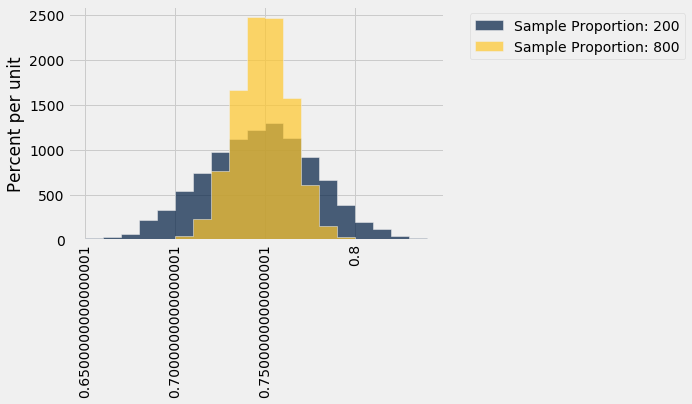

In [25]:
print(results)
results.hist(bins=np.arange(0.65, 0.85, 0.01))

Both distributions are approximately normal but one is narrower than the other. The proportions based on a sample size of 800 are more tightly clustered around 0.75 than those from a sample size of 200. Increasing the sample size has decreased the variability in the sample proportion.

This should not be surprising.  We have leaned many times on the intuition that a larger sample size generally reduces the variability of a statistic.  However, in the case of a sample average, we can *quantify* the relationship between sample size and variability.

Exactly how does the sample size affect the variability of a sample average or proportion? That is the question we will examine in the next section.

# Unit 5: Variability of the Sample Mean

In [26]:
from datascience import *
import numpy as np
path_data = 'https://gitlab.com/tae-public/data/raw/master/cs61/data8assets/textbook/chapters/'
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### The Variability of the Sample Mean ###
By the Central Limit Theorem, the probability distribution of the mean of a large random sample is roughly normal. The bell curve is centered at the population mean. Some of the sample means are higher, and some lower, but the deviations from the population mean are roughly symmetric on either side, as we have seen repeatedly. Formally, probability theory shows that the sample mean is an *unbiased* estimate of the population mean.

In our simulations, we also noticed that the means of larger samples tend to be more tightly clustered around the population mean than means of smaller samples. In this section, we will quantify the variability of the sample mean and develop a relation between **the variability and the sample size**.

Let's start with our table of flight delays. The mean delay is about 16.7 minutes, and the distribution of delays is skewed to the right.

In [27]:
#united = Table.read_table(path_data + 'united_summer2015.csv')
united = Table.read_table('DataFiles/united_summer2015.csv')

delay = united.select('Delay')

In [28]:
pop_mean = np.mean(delay.column('Delay'))
pop_mean

16.658155515370705

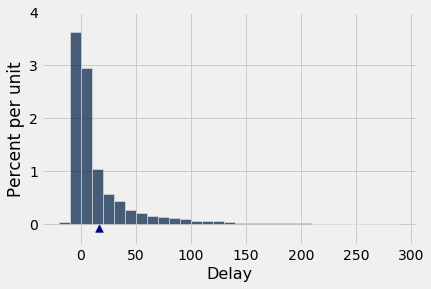

In [29]:
delay.hist(bins=np.arange(-20, 300, 10))
plots.scatter(pop_mean, -0.0008, marker='^', color='darkblue', s=60)
plots.ylim(-0.004, 0.04);

Now let's take random samples and look at the probability distribution of the sample mean. As usual, we will use simulation to get an empirical approximation to this distribution.

We will define a function `simulate_sample_mean` to do this, because we are going to vary the sample size later. The arguments are the name of the table, the label of the column containing the variable, the sample size, and the number of simulations.

In [30]:
"""Empirical distribution of random sample means"""

def simulate_sample_mean(table, label, sample_size, repetitions):
    
    means = make_array()

    for i in range(repetitions):
        new_sample = table.sample(sample_size)
        new_sample_mean = np.mean(new_sample.column(label))
        means = np.append(means, new_sample_mean)

    sample_means = Table().with_column('Sample Means', means)
    
    # Display empirical histogram and print all relevant quantities
    sample_means.hist(bins=20)
    plots.xlabel('Sample Means')
    plots.title('Sample Size ' + str(sample_size))
    print("Sample size: ", sample_size)
    print("Population mean:", np.mean(table.column(label)))
    print("Average of sample means: ", np.mean(means))
    print("Population SD:", np.std(table.column(label)))
    print("SD of sample means:", np.std(means))

Let us simulate the mean of a random sample of 100 delays, then of 400 delays, and finally of 625 delays. We will perform 10,000 repetitions of each of these process. The `xlim` and `ylim` lines set the axes consistently in all the plots for ease of comparison. You can just ignore those two lines of code in each cell.

Sample size:  100
Population mean: 16.658155515370705
Average of sample means:  16.673269
Population SD: 39.480199851609314
SD of sample means: 3.9777485797419376


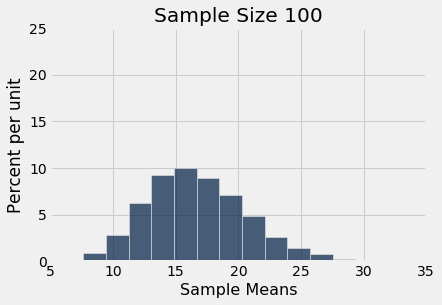

In [31]:
simulate_sample_mean(delay, 'Delay', 100, 10000)
plots.xlim(5, 35)
plots.ylim(0, 0.25);

Sample size:  400
Population mean: 16.658155515370705
Average of sample means:  16.66965825
Population SD: 39.480199851609314
SD of sample means: 1.9952155657552237


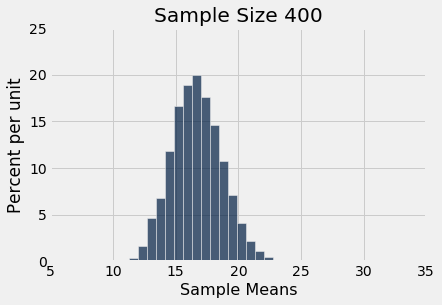

In [32]:
simulate_sample_mean(delay, 'Delay', 400, 10000)
plots.xlim(5, 35)
plots.ylim(0, 0.25);

Sample size:  625
Population mean: 16.658155515370705
Average of sample means:  16.68626816
Population SD: 39.480199851609314
SD of sample means: 1.5687196123495792


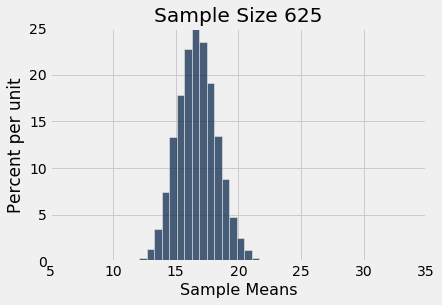

In [33]:
simulate_sample_mean(delay, 'Delay', 625, 10000)
plots.xlim(5, 35)
plots.ylim(0, 0.25);

You can see the Central Limit Theorem in action – the histograms of the sample means are roughly normal, even though the histogram of the delays themselves is far from normal.

You can also see that each of the three histograms of the sample means is centered very close to the population mean. In each case, the "average of sample means" is very close to 16.66 minutes, the population mean. Both values are provided in the printout above each histogram. As expected, the sample mean is an unbiased estimate of the population mean.

### The SD of All the Sample Means ###

You can also see that the histograms get narrower, and hence taller, as the sample size increases. We have seen that before, but now we will pay closer attention to the measure of spread.

The SD of the population of all delays is about 40 minutes.

In [34]:
pop_sd = np.std(delay.column('Delay'))
pop_sd

39.480199851609314

Take a look at the SDs in the sample mean histograms above. In all three of them, the SD of the population of delays is about 40 minutes, because all the samples were taken from the same population.

Now look at the SD of all 10,000 sample means, when the sample size is 100. That SD is about one-tenth of the population SD. When the sample size is 400, the SD of all the sample means is about one-twentieth of the population SD. When the sample size is 625, the SD of the sample means is about one-twentyfifth of the population SD.

It seems like a good idea to compare the SD of the empirical distribution of the sample means to the quantity "population SD divided by the square root of the sample size."

Here are the numerical values. For each sample size in the first column, 10,000 random samples of that size were drawn, and the 10,000 sample means were calculated. The second column contains the SD of those 10,000 sample means. The third column contains the result of the calculation "population SD divided by the square root of the sample size."

The cell takes a while to run, as it's a large simulation. But you'll soon see that it's worth the wait.

In [35]:
repetitions = 10000
sample_sizes = np.arange(25, 626, 25)

sd_means = make_array()

for n in sample_sizes:
    means = make_array()
    for i in np.arange(repetitions):
        means = np.append(means, np.mean(delay.sample(n).column('Delay')))
    sd_means = np.append(sd_means, np.std(means))

sd_comparison = Table().with_columns(
    'Sample Size n', sample_sizes,
    'SD of 10,000 Sample Means', sd_means,
    'pop_sd/sqrt(n)', pop_sd/np.sqrt(sample_sizes)
)

In [36]:
sd_comparison

Sample Size n,"SD of 10,000 Sample Means",pop_sd/sqrt(n)
25,7.81622,7.89604
50,5.5641,5.58334
75,4.56035,4.55878
100,3.94085,3.94802
125,3.49105,3.53122
150,3.20294,3.22354
175,2.98569,2.98442
200,2.8071,2.79167
225,2.59005,2.63201
250,2.49459,2.49695


The values in the second and third columns are very close. If we plot each of those columns with the sample size on the horizontal axis, the two graphs are essentially indistinguishable.

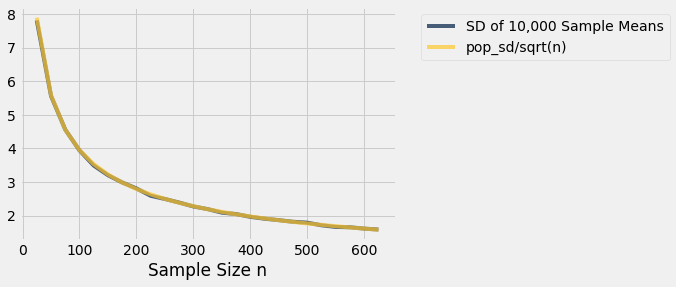

In [37]:
sd_comparison.plot('Sample Size n')

There really are two curves there. But they are so close to each other that it looks as though there is just one.

What we are seeing is an instance of a general result. Remember that the graph above is based on 10,000 replications for each sample size. But there are many more than 10,000 samples of each size. The probability distribution of the sample mean is based on the means of *all possible samples* of a fixed size.

**Fix a sample size.** If the samples are drawn at random with replacement from the population, then

$$
{\mbox{SD of all possible sample means}} ~=~
\frac{\mbox{Population SD}}{\sqrt{\mbox{sample size}}}
$$

This is the standard deviation of the averages of all the possible samples that could be drawn. **It measures roughly how far off the sample means are from the population mean.**

### The Central Limit Theorem for the Sample Mean ###
If you draw a large random sample with replacement from a population, then, regardless of the distribution of the population, the probability distribution of the sample mean is roughly normal, centered at the population mean, with an SD equal to the population SD divided by the square root of the sample size.

### The Accuracy of the Sample Mean ###
The SD of all possible sample means measures how variable the sample mean can be. As such, it is taken as a measure of the accuracy of the sample mean as an estimate of the population mean. The smaller the SD, the more accurate the estimate.

The formula shows that:
- The population size doesn't affect the accuracy of the sample mean. The population size doesn't appear anywhere in the formula.
- The population SD is a constant; it's the same for every sample drawn from the population. The sample size can be varied. Because the sample size appears in the denominator, the variability of the sample mean *decreases* as the sample size increases, and hence the accuracy increases.

### The Square Root Law ###
From the table of SD comparisons, you can see that the SD of the means of random samples of 25 flight delays is about 8 minutes. If you multiply the sample size by 4, you'll get samples of size 100. The SD of the means of all of those samples is about 4 minutes. That's smaller than 8 minutes, but it's not 4 times as small; it's only 2 times as small. That's because the sample size in the denominator has a square root over it. The sample size increased by a factor of 4, but the SD went down by a factor of $2 = \sqrt{4}$. In other words, the accuracy went up by a factor of $2 = \sqrt{4}$.

In general, when you multiply the sample size by a factor, the accuracy of the sample mean goes up by the square root of that factor.

So to increase accuracy by a factor of 10, you have to multiply sample size by a factor of 100. Accuracy doesn't come cheap!

# Unit 6: Choosing a Sample Size

In [42]:
from datascience import *
import numpy as np
path_data = 'https://gitlab.com/tae-public/data/raw/master/cs61/data8assets/textbook/chapters/'
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### Choosing a Sample Size ###
Candidate A is contesting an election. A polling organization wants to estimate the proportion of voters who will vote for her. Let's suppose that they plan to take a simple random sample of voters, though in reality their method of sampling would be more complex. How can they decide how large their sample should be, to get a desired level of accuracy?

We are now in a position to answer this question, after making a few assumptions:
- The population of voters is very large and that therefore we can just as well assume that the random sample will be drawn with replacement.
- The polling organization will make its estimate by constructing an approximate 95% confidence interval for the percent of voters who will vote for Candidate A.
- The desired level of accuracy is that the width of the interval should be no more than 1%. That's pretty accurate! For example, the confidence interval (33.2%, 34%) would be fine but (33.2%, 35%) would not.

We will work with the sample proportion of voters for Candidate A. Recall that a proportion is a mean, when the values in the population are only 0 (the type of individual you are not counting) or 1 (the type of individual you are counting).

### Width of Confidence Interval ###
If we had a random sample, we could go about using the bootstrap to construct a confidence interval for the percent of voters for Candidate A. But we don't have a sample yet – we are trying to find out how big the sample has to be so that our confidence interval is as narrow as we want it to be.

In situations like this, it helps to see what theory predicts.

The Central Limit Theorem says that the probabilities for the sample proportion are roughly normally distributed, centered at the population proportion of 1's, with an SD equal to the SD of the population of 0's and 1's divided by the square root of the sample size.

So the confidence interval will still be the "middle 95%" of a normal distribution, even though we can't pick off the ends as the 2.5th and 97.5th percentiles of bootstrapped proportions. 

Is there another way to find how wide the interval would be? Yes, because we know that for normally distributed variables, the interval "center $\pm$ 2 SDs" contains 95% of the data.

The confidence interval will stretch for 2 SDs of the sample proportion, on either side of the center. So the width of the interval will be 4 SDs of the sample proportion.

We are willing to tolerate a width of 1% = 0.01. So, using the formula developed in the last section, 

$$
4 \times \frac{\mbox{SD of the 0-1 population}}{\sqrt{\mbox{sample size}}}
~ \le ~ 0.01
$$

So

$$
\sqrt{\mbox{sample size}} ~ \ge ~ 4 \times \frac{\mbox{SD of the 0-1 population}}{0.01}
$$

### The SD of a collection of 0's and 1's ###
If we knew the SD of the population, we'd be done. We could calculate the square root of the sample size, and then take the square to get the sample size. But we don't know the SD of the population. The population consists of 1 for each voter for Candidate A, and 0 for all other voters, and *we don't know what proportion of each kind there are.* That's what we're trying to estimate.

So are we stuck? No, because we can *bound* the SD of the population. Here are histograms of two such distributions, one for an equal proportion of 1's and 0's, and one with 90% 1's and 10% 0's. Which one has the bigger SD? 

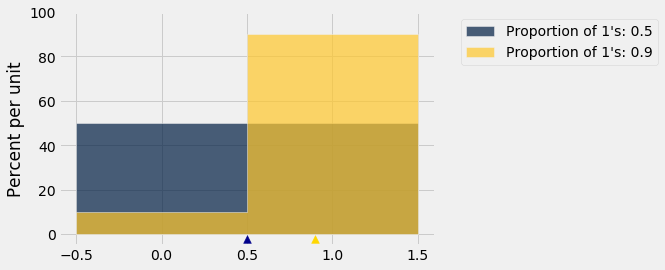

In [43]:
# HIDDEN 
pop_50 = make_array(1, 1, 1, 1, 1, 0, 0, 0, 0, 0)
pop_90 = make_array(1, 1, 1, 1, 1, 1, 1, 1, 1, 0)

coins = Table().with_columns(
   "Proportion of 1's: 0.5", pop_50,
   "Proportion of 1's: 0.9", pop_90,
)
coins.hist(bins=np.arange(-0.5, 1.6, 1))
plots.scatter(0.5, -0.02, marker='^', color='darkblue', s=60)
plots.scatter(0.9, -0.02, marker='^', color='gold', s=60)
plots.ylim(-0.05, 1);

Remember that the possible values in the population are only 0 and 1.

The blue histogram (50% 1's and 50% 0's) has more spread than the gold. The mean is 0.5. Half the deviations from mean are equal to 0.5 and the other half equal to -0.5, so the SD is 0.5.

In the gold histogram, all of the area is being squished up around 1, leading to less spread. 90% of the deviations are small: 0.1. The other 10% are -0.9 which is large, but overall the spread is smaller than in the blue histogram.

The same observation would hold if we varied the proportion of 1's or let the proportion of 0's be larger than the proportion of 1's. Let's check this by calculating the SDs of populations of 10 elements that only consist of 0's and 1's, in varying proportions. The function `np.ones` is useful for this. It takes a positive integer as its argument and returns an array consisting of that many 1's.

In [44]:
sd = make_array()
for i in np.arange(1, 10, 1):
    # Create an array of i 1's and (10-i) 0's
    population = np.append(np.ones(i), 1-np.ones(10-i))
    sd = np.append(sd, np.std(population))
    
zero_one_sds = Table().with_columns(
    "Population Proportion of 1's", np.arange(0.1, 1, 0.1),
    "Population SD", sd
)

zero_one_sds

Population Proportion of 1's,Population SD
0.1,0.3
0.2,0.4
0.3,0.458258
0.4,0.489898
0.5,0.5
0.6,0.489898
0.7,0.458258
0.8,0.4
0.9,0.3


Not surprisingly, the SD of a population with 10% 1's and 90% 0's is the same as that of a population with 90% 1's and 10% 0's. That's because you switch the bars of one histogram to get the other; there is no change in spread.

More importantly for our purposes, the SD increases as the proportion of 1's increases, until the proportion of 1's is 0.5; then it starts to decrease symmetrically.

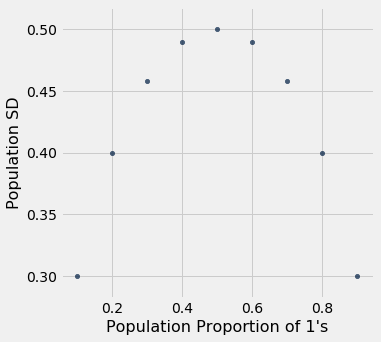

In [41]:
zero_one_sds.scatter("Population Proportion of 1's")

**Summary:** The SD of a population of 1's and 0's is at most 0.5. That's the value of the SD when 50% of the population is coded 1 and the other 50% are coded 0.

### The Sample Size ###
We know that 
$$
\sqrt{\mbox{sample size}} ~ \ge ~ 4 \times \frac{\mbox{SD of the 0-1 population}}{0.01}
$$
and that the SD of the 0-1 population is at most 0.5, regardless of the proportion of 1's in the population. So it is safe to take

$$
\sqrt{\mbox{sample size}} ~ \ge ~ 4 \times \frac{0.5}{0.01} ~=~ 200
$$

So the sample size should be at least $200^2 = 40,000$. That's an enormous sample! But that's what you need if you want to guarantee great accuracy with high confidence no matter what the population looks like.